# YOLO MVTec Bottle Pipeline Report

This notebook documents the data preparation, augmentation statistics, model evaluation, and qualitative inspection for the YOLO-based anomaly detector trained on the MVTec Bottle subset. All explanations and comments are provided in English as requested.


In [103]:
%matplotlib inline

from pathlib import Path
from collections import Counter
import json
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from PIL import Image
import numpy as np

sns.set_theme(style="whitegrid")


In [104]:
BASE_DIR = Path("/Users/vantrinh/Work/python/yolo")
ORIG_DATASET = BASE_DIR / "datasets/mvtec/bottle"
YOLO_DATASET = BASE_DIR / "datasets/yolo_mvtec_bottle"
YOLO_YAML = BASE_DIR / "datasets/yolo_mvtec_bottle.yaml"
MODEL_DIR = BASE_DIR / "runs/yolo_mvtec/yolon_20251119_011644"
MODEL_PATH = MODEL_DIR / "weights/best.pt"

print("Original dataset:", ORIG_DATASET)
print("YOLO dataset:", YOLO_DATASET)
print("Model path:", MODEL_PATH)



Original dataset: /Users/vantrinh/Work/python/yolo/datasets/mvtec/bottle
YOLO dataset: /Users/vantrinh/Work/python/yolo/datasets/yolo_mvtec_bottle
Model path: /Users/vantrinh/Work/python/yolo/runs/yolo_mvtec/yolon_20251119_011644/weights/best.pt


## Dataset Overview

The tables below compare the original MVTec Bottle split with the YOLO-ready dataset (after mask conversion and augmentation). The augmentation breakdown counts how many training images came from each transformation suffix.


In [105]:
def count_images(folder: Path, exts=(".png", ".jpg", ".jpeg")):
    return sum(1 for p in folder.rglob("*") if p.suffix.lower() in exts)


def summarize_original_dataset(root: Path):
    rows = []
    train_good = root / "train/good"
    rows.append({"dataset": "Original", "split": "train/good", "class": "good", "count": count_images(train_good)})
    test_dir = root / "test"
    for sub in sorted(test_dir.iterdir()):
        if sub.is_dir():
            label = "good" if sub.name == "good" else "defect"
            rows.append({"dataset": "Original", "split": f"test/{sub.name}", "class": label, "count": count_images(sub)})
    return pd.DataFrame(rows)


def summarize_yolo_dataset(root: Path):
    rows = []
    for split in ["train", "val"]:
        img_dir = root / split / "images"
        label_dir = root / split / "labels"
        rows.append({"dataset": "YOLO", "split": f"{split}/images", "class": "-", "count": count_images(img_dir, exts=(".jpg", ".jpeg"))})
        rows.append({"dataset": "YOLO", "split": f"{split}/labels", "class": "-", "count": count_images(label_dir, exts=(".txt",))})
    return pd.DataFrame(rows)


def count_augmented_variants(img_dir: Path):
    suffixes = ["flip_h", "flip_v", "rot_p15", "rot_n15", "blur"]
    stats = Counter()
    total = 0
    for img_path in img_dir.glob("*.jpg"):
        total += 1
        added = False
        for suffix in suffixes:
            if f"_{suffix}" in img_path.stem:
                stats[suffix] += 1
                added = True
                break
        if not added:
            stats["original"] += 1
    stats["total"] = total
    return stats

orig_summary = summarize_original_dataset(ORIG_DATASET)
yolo_summary = summarize_yolo_dataset(YOLO_DATASET)
train_aug_stats = count_augmented_variants(YOLO_DATASET / "train/images")
val_aug_stats = count_augmented_variants(YOLO_DATASET / "val/images")

orig_summary, yolo_summary, train_aug_stats, val_aug_stats



(    dataset               split   class  count
 0  Original          train/good    good    209
 1  Original   test/broken_large  defect     20
 2  Original   test/broken_small  defect     22
 3  Original  test/contamination  defect     21
 4  Original           test/good    good     20,
   dataset         split class  count
 0    YOLO  train/images     -   5456
 1    YOLO  train/labels     -   5456
 2    YOLO    val/images     -     51
 3    YOLO    val/labels     -     51,
 Counter({'total': 5456,
          'flip_h': 1760,
          'flip_v': 1408,
          'rot_p15': 1056,
          'rot_n15': 704,
          'blur': 352,
          'original': 176}),
 Counter({'original': 51, 'total': 51}))

In [106]:
display(orig_summary)
display(yolo_summary)

train_aug_df = pd.DataFrame([train_aug_stats])
val_aug_df = pd.DataFrame([val_aug_stats])

print("Train augmentation breakdown:")
display(train_aug_df)
print("Val augmentation breakdown:")
display(val_aug_df)



,dataset,split,class,count
0,Original,train/good,good,209
1,Original,test/broken_large,defect,20
2,Original,test/broken_small,defect,22
3,Original,test/contamination,defect,21
4,Original,test/good,good,20


,dataset,split,class,count
0,YOLO,train/images,-,5456
1,YOLO,train/labels,-,5456
2,YOLO,val/images,-,51
3,YOLO,val/labels,-,51


Train augmentation breakdown:


,rot_p15,original,flip_h,flip_v,rot_n15,blur,total
0,1056,176,1760,1408,704,352,5456


Val augmentation breakdown:


,original,total
0,51,51


## Model Evaluation

We load the trained checkpoint and run a full validation pass on the YOLO dataset to obtain detection metrics.


## Training Configuration

This section displays the training hyperparameters and configuration used to train the YOLO model.


In [107]:
# Load training configuration
args_yaml_path = MODEL_DIR / "args.yaml"
training_config = None

if args_yaml_path.exists():
    with open(args_yaml_path, 'r') as f:
        training_config = yaml.safe_load(f)
    print("✓ Training configuration loaded")
else:
    print(f"⚠️  Training config not found at {args_yaml_path}")

# Display key training parameters
if training_config:
    config_df = pd.DataFrame([
        {"Parameter": "Model", "Value": training_config.get("model", "N/A")},
        {"Parameter": "Task", "Value": training_config.get("task", "N/A")},
        {"Parameter": "Mode", "Value": training_config.get("mode", "N/A")},
        {"Parameter": "Epochs", "Value": training_config.get("epochs", "N/A")},
        {"Parameter": "Batch size", "Value": training_config.get("batch", "N/A")},
        {"Parameter": "Image size", "Value": training_config.get("imgsz", "N/A")},
        {"Parameter": "Device", "Value": training_config.get("device", "N/A")},
        {"Parameter": "Learning rate (lr0)", "Value": training_config.get("lr0", "N/A")},
        {"Parameter": "Final LR (lrf)", "Value": training_config.get("lrf", "N/A")},
        {"Parameter": "Optimizer", "Value": training_config.get("optimizer", "N/A")},
        {"Parameter": "Weight decay", "Value": training_config.get("weight_decay", "N/A")},
        {"Parameter": "Momentum", "Value": training_config.get("momentum", "N/A")},
        {"Parameter": "Warmup epochs", "Value": training_config.get("warmup_epochs", "N/A")},
        {"Parameter": "Data augmentation", "Value": "Yes" if training_config.get("augment", False) else "No"},
        {"Parameter": "Mosaic", "Value": training_config.get("mosaic", "N/A")},
        {"Parameter": "Mixup", "Value": training_config.get("mixup", "N/A")},
        {"Parameter": "Dataset", "Value": training_config.get("data", "N/A")},
    ])
    display(config_df)
else:
    print("Training configuration unavailable")



✓ Training configuration loaded


,Parameter,Value
0,Model,yolo11n.pt
1,Task,detect
2,Mode,train
3,Epochs,100
4,Batch size,16
5,Image size,640
6,Device,mps
7,Learning rate (lr0),0.01
8,Final LR (lrf),0.01
9,Optimizer,auto


✓ Training results loaded (100 epochs)

Final epoch metrics:


,Metric,Value
0,Epoch,100.0
1,Train Box Loss,1.0949
2,Train Class Loss,1.0372
3,Train DFL Loss,1.4600
4,Validation mAP50,0.9530
5,Validation mAP50-95,0.5899
6,Validation Precision,0.9841
7,Validation Recall,0.8571


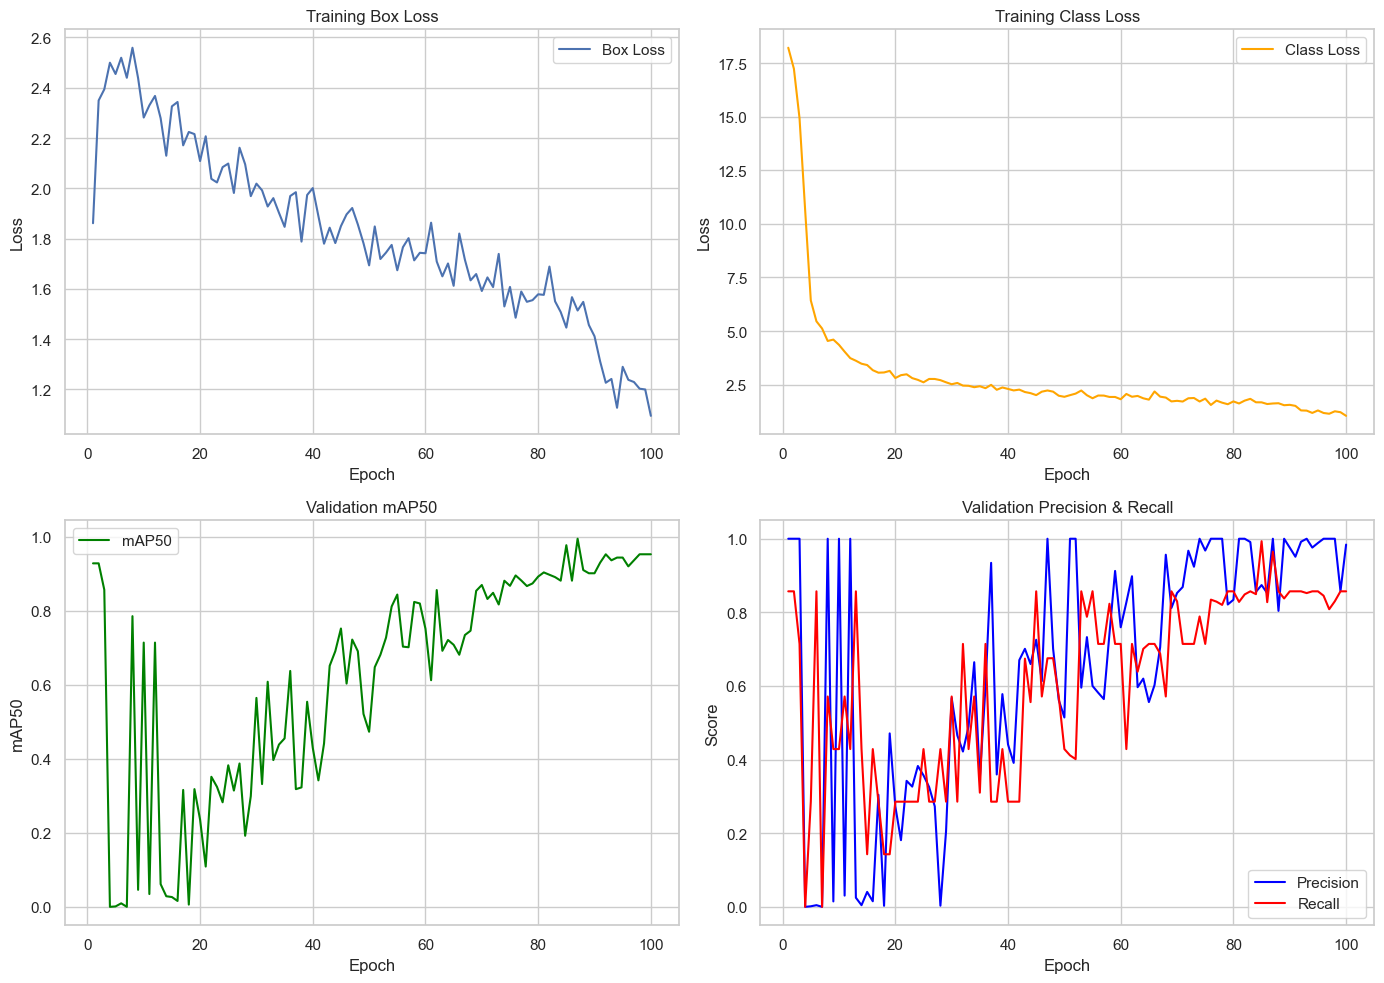

In [108]:
# Load and display training results
results_csv_path = MODEL_DIR / "results.csv"

if results_csv_path.exists():
    results_df = pd.read_csv(results_csv_path)
    results_df.columns = results_df.columns.str.strip()  # Remove extra spaces
    
    print(f"✓ Training results loaded ({len(results_df)} epochs)")
    print("\nFinal epoch metrics:")
    
    # Get last epoch metrics
    last_epoch = results_df.iloc[-1]
    
    final_metrics_df = pd.DataFrame([
        {"Metric": "Epoch", "Value": last_epoch.get("epoch", "N/A")},
        {"Metric": "Train Box Loss", "Value": f"{last_epoch.get('train/box_loss', 0):.4f}"},
        {"Metric": "Train Class Loss", "Value": f"{last_epoch.get('train/cls_loss', 0):.4f}"},
        {"Metric": "Train DFL Loss", "Value": f"{last_epoch.get('train/dfl_loss', 0):.4f}"},
        {"Metric": "Validation mAP50", "Value": f"{last_epoch.get('metrics/mAP50(B)', 0):.4f}"},
        {"Metric": "Validation mAP50-95", "Value": f"{last_epoch.get('metrics/mAP50-95(B)', 0):.4f}"},
        {"Metric": "Validation Precision", "Value": f"{last_epoch.get('metrics/precision(B)', 0):.4f}"},
        {"Metric": "Validation Recall", "Value": f"{last_epoch.get('metrics/recall(B)', 0):.4f}"},
    ])
    
    display(final_metrics_df)
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss curves
    if 'train/box_loss' in results_df.columns:
        axes[0, 0].plot(results_df['epoch'], results_df['train/box_loss'], label='Box Loss')
        axes[0, 0].set_title('Training Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
    
    if 'train/cls_loss' in results_df.columns:
        axes[0, 1].plot(results_df['epoch'], results_df['train/cls_loss'], label='Class Loss', color='orange')
        axes[0, 1].set_title('Training Class Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # mAP curves
    if 'metrics/mAP50(B)' in results_df.columns:
        axes[1, 0].plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50', color='green')
        axes[1, 0].set_title('Validation mAP50')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP50')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Precision/Recall
    if 'metrics/precision(B)' in results_df.columns and 'metrics/recall(B)' in results_df.columns:
        axes[1, 1].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision', color='blue')
        axes[1, 1].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall', color='red')
        axes[1, 1].set_title('Validation Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"⚠️  Training results not found at {results_csv_path}")



In [109]:
model = YOLO(str(MODEL_PATH))
val_results = model.val(data=str(YOLO_YAML), split="val", conf=0.25, imgsz=640)
metrics = val_results.results_dict
metrics


Ultralytics 8.3.225 🚀 Python-3.14.0 torch-2.9.0 CPU (Apple M1 Pro)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 468.1±143.9 MB/s, size: 141.3 KB)
val: Scanning /Users/vantrinh/Work/python/yolo/datasets/yolo_mvtec_bottle/val/labels.cache... 51 images, 44 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 51/51 181.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.4it/s 9.3s4.6ss
                   all         51          7          0          0          0          0
                defect          7          7          0          0          0          0
Speed: 0.9ms preprocess, 176.1ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /Users/vantrinh/Work/python/yolo/runs/detect/val14


{'metrics/precision(B)': 0.0,
 'metrics/recall(B)': 0.0,
 'metrics/mAP50(B)': 0.0,
 'metrics/mAP50-95(B)': 0.0,
 'fitness': 0.0}

In [110]:
summary_df = pd.DataFrame([
    {
        "metric": "mAP50",
        "value": metrics.get("metrics/mAP50(B)", float("nan"))
    },
    {
        "metric": "mAP50-95",
        "value": metrics.get("metrics/mAP50-95(B)", float("nan"))
    },
    {
        "metric": "Precision",
        "value": metrics.get("metrics/precision(B)", float("nan"))
    },
    {
        "metric": "Recall",
        "value": metrics.get("metrics/recall(B)", float("nan"))
    }
])
summary_df


,metric,value
0,mAP50,0.0
1,mAP50-95,0.0
2,Precision,0.0
3,Recall,0.0


In [111]:
precision = metrics.get("metrics/precision(B)")
recall = metrics.get("metrics/recall(B)")
model_score = None
if precision is not None and recall is not None:
    model_score = (precision + recall) / 2.0

score_df = pd.DataFrame([
    {"metric": "Precision", "value": precision},
    {"metric": "Recall", "value": recall},
    {"metric": "Composite score (avg precision & recall)", "value": model_score}
])
score_df


,metric,value
0,Precision,0.0
1,Recall,0.0
2,Composite score (avg precision & recall),0.0


### Model Scorecard

The table below mirrors the console “OVERALL METRICS” block: Accuracy, Precision, Recall, F1, composite score (average of precision & recall), and a confidence score (using precision as a proxy of detector confidence).


In [112]:
metrics_file = BASE_DIR / "runs/yolo_mvtec/inference_val/metrics.json"
if metrics_file.exists():
    with open(metrics_file) as f:
        eval_metrics = json.load(f)
else:
    eval_metrics = None
    print(f"Warning: {metrics_file} not found. Run inference_yolo.py with --output_dir runs/yolo_mvtec/inference_val to generate it.")

overall_table = None
if eval_metrics is not None:
    overall_table = pd.DataFrame([
        {"metric": "Accuracy", "value": eval_metrics.get("accuracy")},
        {"metric": "Precision", "value": eval_metrics.get("precision")},
        {"metric": "Recall", "value": eval_metrics.get("recall")},
        {"metric": "F1 Score", "value": eval_metrics.get("f1")},
        {"metric": "Defect detection rate", "value": eval_metrics.get("defect_detection_rate")},
        {"metric": "Composite score", "value": eval_metrics.get("score")},
        {"metric": "Confidence (precision proxy)", "value": eval_metrics.get("precision")},
    ])
    display(overall_table)
else:
    print("Overall metrics table unavailable.")


,metric,value
0,Accuracy,0.862745
1,Precision,1.000000
2,Recall,0.862745
3,F1 Score,0.926316
4,Defect detection rate,0.000000
5,Composite score,0.931373
6,Confidence (precision proxy),1.000000


In [113]:
if eval_metrics is not None:
    print("OVERALL METRICS (from inference_yolo.py)")
    print("=" * 60)
    print(f"Accuracy : {eval_metrics.get('accuracy', 0) * 100:6.2f}%")
    print(f"Precision: {eval_metrics.get('precision', 0) * 100:6.2f}%")
    print(f"Recall   : {eval_metrics.get('recall', 0) * 100:6.2f}%")
    print(f"F1-Score : {eval_metrics.get('f1', 0) * 100:6.2f}%")
    print(f"Defect detection rate: {eval_metrics.get('defect_detection_rate', 0) * 100:6.2f}%")
    print(f"Composite: {eval_metrics.get('score', 0) * 100:6.2f}%")
    print(f"Confidence: {eval_metrics.get('precision', 0) * 100:6.2f}%")
else:
    print("Run inference_yolo.py with metrics export to populate this section.")


OVERALL METRICS (from inference_yolo.py)
Accuracy :  86.27%
Precision: 100.00%
Recall   :  86.27%
F1-Score :  92.63%
Defect detection rate:   0.00%
Composite:  93.14%
Confidence: 100.00%


## Qualitative Inspection

We inspect a handful of images (two defect cases and two good cases) and visualize the model outputs to verify whether bounding boxes and class predictions look reasonable.


Running inference on sample images...

0: 640x640 (no detections), 48.3ms
1: 640x640 (no detections), 48.3ms
2: 640x640 (no detections), 48.3ms
3: 640x640 (no detections), 48.3ms
Speed: 1.9ms preprocess, 48.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


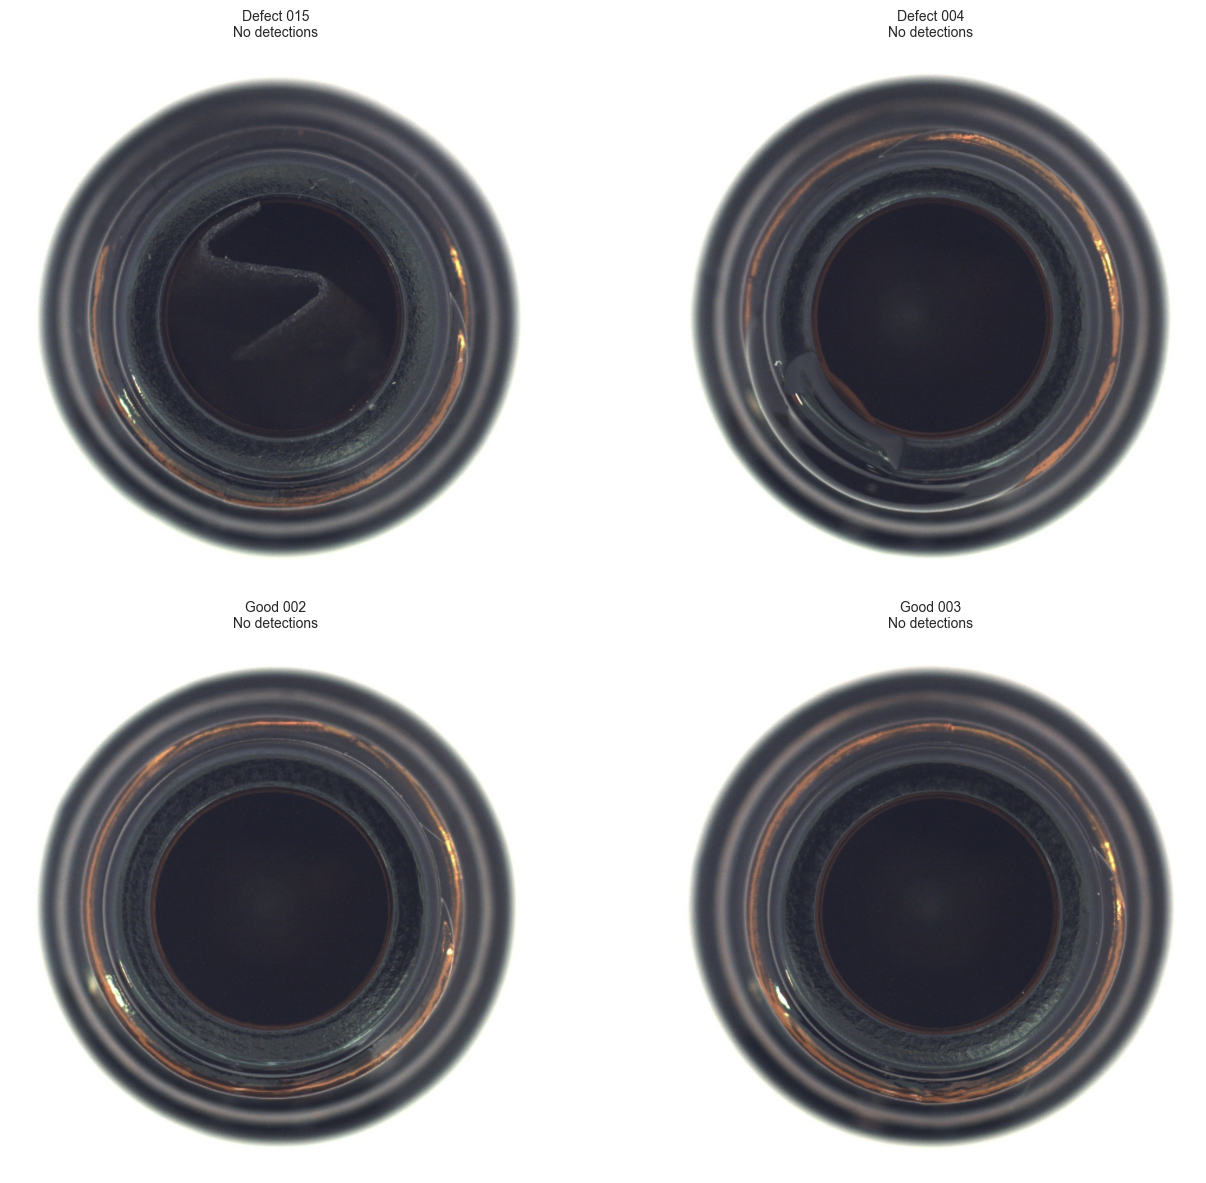


INDIVIDUAL IMAGE DETECTION DETAILS

Defect 015:
  ✗ No detections (classified as: good)

Defect 004:
  ✗ No detections (classified as: good)

Good 002:
  ✗ No detections (classified as: good)

Good 003:
  ✗ No detections (classified as: good)


In [114]:
# Load model if not already loaded
if 'model' not in locals():
    print("Loading YOLO model...")
    model = YOLO(str(MODEL_PATH))
    print(f"✓ Model loaded from {MODEL_PATH}")

# Select sample images and run inference
sample_defect = [
    YOLO_DATASET / "val/images/015.jpg",
    YOLO_DATASET / "val/images/004.jpg",
]
sample_good = [
    YOLO_DATASET / "val/images/002.jpg",
    YOLO_DATASET / "val/images/003.jpg",
]

sample_paths = sample_defect + sample_good
sample_titles = ["Defect 015", "Defect 004", "Good 002", "Good 003"]

print("Running inference on sample images...")
pred_results = model.predict(sample_paths, conf=0.25, imgsz=640)

# Display annotated images with detection results drawn on them (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (ax, title, res) in enumerate(zip(axes, sample_titles, pred_results)):
    # Get the annotated image with bounding boxes drawn by YOLO
    plotted = res.plot()  # numpy array in BGR
    rgb_image = plotted[..., ::-1]  # Convert to RGB
    
    ax.imshow(rgb_image)
    
    # Add title with detection summary
    if res.boxes is not None and len(res.boxes) > 0:
        confs = res.boxes.conf.cpu().numpy()
        classes = res.boxes.cls.cpu().numpy().astype(int)
        names = [model.names[int(c)] for c in classes]
        
        # Create detection summary
        det_summary = []
        for name, cls, conf in zip(names, classes, confs):
            det_summary.append(f"{name}: {conf:.2f}")
        
        subtitle = f"{title}\n" + ", ".join(det_summary)
        ax.set_title(subtitle, fontsize=10, pad=10)
    else:
        ax.set_title(f"{title}\nNo detections", fontsize=10, pad=10)
    
    ax.axis("off")

plt.tight_layout()
plt.show()

# Display detailed results for each image
print("\n" + "="*60)
print("INDIVIDUAL IMAGE DETECTION DETAILS")
print("="*60)

for title, res in zip(sample_titles, pred_results):
    print(f"\n{title}:")
    
    # Display detection details in text
    if res.boxes is not None and len(res.boxes) > 0:
        for box in res.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            class_name = model.names[cls]
            xyxy = box.xyxy[0].cpu().numpy()
            
            print(f"  ✓ Detected: {class_name} (confidence: {conf:.4f})")
            print(f"    Box: [{xyxy[0]:.1f}, {xyxy[1]:.1f}, {xyxy[2]:.1f}, {xyxy[3]:.1f}]")
    else:
        print(f"  ✗ No detections (classified as: good)")



In [115]:
sample_summaries = []
for title, img_path, res in zip(sample_titles, sample_paths, pred_results):
    if res.boxes is None or len(res.boxes) == 0:
        sample_summaries.append({
            "image": title,
            "pred_class": None,
            "confidence": None,
            "bbox": None
        })
    else:
        for cls_id, conf, box in zip(res.boxes.cls.cpu().numpy().astype(int),
                                      res.boxes.conf.cpu().numpy(),
                                      res.boxes.xywh.cpu().numpy()):
            sample_summaries.append({
                "image": title,
                "pred_class": cls_id,
                "confidence": float(conf),
                "bbox": box.round(3)
            })

pd.DataFrame(sample_summaries)



,image,pred_class,confidence,bbox
0,Defect 015,None,None,None
1,Defect 004,None,None,None
2,Good 002,None,None,None
3,Good 003,None,None,None


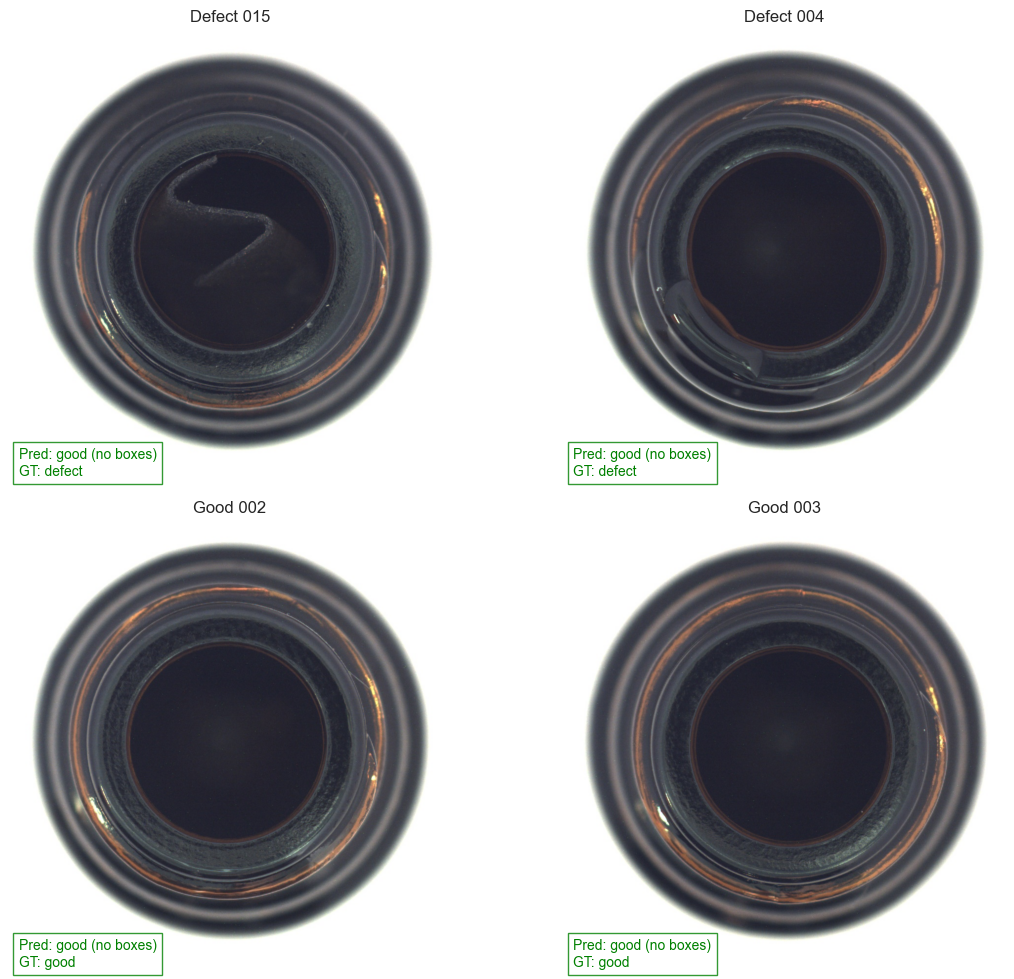

In [116]:
gt_labels = ["defect", "defect", "good", "good"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, title, path, res, gt in zip(axes, sample_titles, sample_paths, pred_results, gt_labels):
    img = Image.open(path).convert("RGB")
    ax.imshow(img)
    if res.boxes is not None and len(res.boxes) > 0:
        conf = float(res.boxes.conf.max().cpu().item())
        pred_label = "defect" if any(int(c) == 1 for c in res.boxes.cls.cpu().numpy()) else "good"
        info = f"Pred: {pred_label} (conf {conf:.2f})\nGT: {gt}"
        color = "red" if pred_label == "defect" else "green"
    else:
        info = f"Pred: good (no boxes)\nGT: {gt}"
        color = "green"
    ax.text(0.02, 0.05, info, transform=ax.transAxes,
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=color),
            color=color, fontsize=10, verticalalignment="top")
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

